https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pygad
plt.style.use('ggplot')

## **Reading the data**

In [239]:
df_train = pd.read_csv('../data/train.csv')

In [240]:
df_train.shape

(414, 8)

## **Overview plots**

In [241]:
# plt.figure(figsize=(10,10))

# sns.pairplot(df_train, hue="target");

In [242]:
df_train.isna().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

## **Class (im)balance**

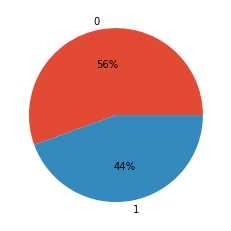

In [243]:
plt.pie(df_train['target'].value_counts(), labels=[0 , 1], autopct='%.0f%%');

## **Initial model**

### Train test split

In [244]:
from sklearn.model_selection import train_test_split

target = df_train['target']
features = df_train.drop(['target', 'id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2)

## **Random Forest**

In [245]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold

skf = StratifiedKFold(n_splits=3)

rf = RandomForestClassifier(n_estimators=50,
                            max_depth=5,
                            random_state=2049,
                            class_weight='balanced')

rf.fit(X_train, y_train)

print(roc_auc_score(y_score=rf.predict_proba(X_test)[:,1], y_true=y_test))



0.8101190476190476


## **XGBoost**

In [246]:
from xgboost import XGBClassifier

skf = StratifiedKFold(n_splits=3)

scale_pos_weight = (target == False).sum()/(target == True).sum()
xgb = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight,
                    n_estimators=100)

xgb.fit(X_train, y_train)
print(roc_auc_score(y_true=y_test, y_score=xgb.predict_proba(X_test)[:, 1]))

0.7291666666666666


## **Feature selection**

In [247]:
features.corrwith(target)

gravity    0.282577
ph        -0.094983
osmo       0.244770
cond       0.172224
urea       0.265211
calc       0.467439
dtype: float64

## **More features!**

- Urine specific gravity
- pH of urine
- Osmolarity of urine
- Conductivity of urine
- Concentration of urea in urine
- Concentration of calcium in urine

What if we combine these features, so the model can get more information about the data?

In [248]:
df_train['cond/ph'] = df_train['cond']/df_train['ph']
df_train['calc/urea'] = df_train['calc']/df_train['urea']
df_train['urea/gravity'] = df_train['urea']/df_train['gravity']

## **Outliers**

In [249]:
def outlier_removal(data , i):
    
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
outlier_list = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'cond/ph', 'calc/urea', 'urea/gravity']
for  i in outlier_list:
    outlier_removal(df_train ,i)

In [250]:
target = df_train['target']
features = df_train.drop(['target', 'id'], axis=1)

features = features.drop('ph', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2)

In [251]:
scale_pos_weight = (target == False).sum()/(target == True).sum()

xgb = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight,
                    n_estimators=100)

xgb.fit(X_train, y_train)

print(roc_auc_score(y_true=y_test, y_score=xgb.predict_proba(X_test)[:, 1]))

0.8133608815426997


In [252]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=5,
                            random_state=2049,
                            class_weight='balanced')

rf.fit(X_train, y_train)

print(roc_auc_score(y_score=rf.predict_proba(X_test)[:,1], y_true=y_test))

0.8112947658402203


## **Tune this GridSearch**

In [253]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 200],
    'max_leaves': [2, 4, 8],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(xgb,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=StratifiedKFold(n_splits=3),
                    verbose=2,
                    n_jobs=-1)

In [254]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 3645 candidates, totalling 10935 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             

In [255]:
grid.best_score_

0.8119580560596894

In [256]:
param_grid = {
    'n_estimators': [10, 50, 200],
    'criterion': ["gini", "log_loss"],
    'min_samples_split': [2, 3, 4],
    'max_features': ["sqrt", "log2"],
    'max_leaf_nodes': np.arange(1, 10, 5)
}

second_param_grid = {'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 8, 10, 12],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50 ,100 ,200, 400, 600, 800, 1000]}

grid = GridSearchCV(rf,
                    param_grid=second_param_grid,
                    scoring='roc_auc',
                    cv=StratifiedKFold(n_splits=3),
                    verbose=3,
                    n_jobs=-1)

In [257]:
grid.fit(X_train, y_train)
grid.best_score_

Fitting 3 folds for each of 2268 candidates, totalling 6804 fits


In [ ]:
features = df_train.drop(['id', 'target'], axis=1).copy()

features['cond/ph'] = features['cond']/features['ph']
features['calc/urea'] = features['calc']/features['urea']
features['urea/gravity'] = features['urea']/features['gravity']
features = features.drop('ph', axis=1)

In [ ]:
grid.fit(features, df_train['target'])
pred = grid.predict_proba(X_test)[:, 1]

In [ ]:
sub = pd.DataFrame()
sub['id'] = df_test['id']
sub['target'] = pred

In [ ]:
sub.to_csv('submission.csv',index=False)